In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_style("ticks",{'axes.grid' : True})

In [2]:
dados = pd.read_csv('linha150.csv',
                    converters={
                        'linha': str,
                        'trajeto': str,
                        'ponto_inicial': str,
                        'ponto_final': str,
                        'servico': str
                    },
                    parse_dates=['data', 'inicior', 'terminor'])


In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68834 entries, 0 to 68833
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   linha          68834 non-null  object        
 1   data           68834 non-null  datetime64[ns]
 2   trajeto        68834 non-null  object        
 3   ponto_inicial  68834 non-null  object        
 4   ponto_final    68834 non-null  object        
 5   servico        68834 non-null  object        
 6   inicior        68834 non-null  datetime64[ns]
 7   terminor       68834 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(5)
memory usage: 4.2+ MB


In [4]:
dados['mintrajeto'] = ((dados['terminor'] - dados['inicior']).dt.total_seconds()/ 60.0).astype('int')
dados['diasemana'] = dados['data'].dt.dayofweek

dias = {0: 'Segunda', 1: 'Terça', 2: 'Quarta',
        3: 'Quinta', 4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}

dados['nomediasemana'] = dados['diasemana'].apply(lambda x: dias[x])


In [5]:
dados.head()

,linha,data,trajeto,ponto_inicial,ponto_final,servico,inicior,terminor,mintrajeto,diasemana,nomediasemana
0,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Cordeiros,Terminal Fazenda,11,2018-01-10 05:25:00,2018-01-10 05:39:00,14,2,Quarta
1,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 05:58:00,2018-01-10 06:12:00,14,2,Quarta
2,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Cordeiros,Terminal Fazenda,11,2018-01-10 06:37:00,2018-01-10 06:54:00,17,2,Quarta
3,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 07:09:00,2018-01-10 07:36:00,27,2,Quarta
4,150,2018-01-10,150_A - Terminal Cordeiros > Terminal Fazenda,Terminal Fazenda,Terminal Cordeiros,11,2018-01-10 07:56:00,2018-01-10 08:25:00,29,2,Quarta


In [15]:
dados['trajeto'].unique()

array(['150_A - Terminal Cordeiros > Terminal Fazenda'], dtype=object)

In [7]:
dados = dados.loc[dados['trajeto'] != '150_B - Univali / T. Fazenda / T. Cordeiros']

# Média mensal (seg./sexta)

In [8]:
dados['ano'] = dados['data'].dt.year
dados['mes'] = dados['data'].dt.month
dados['dia'] = dados['data'].dt.day

dados_dias_semana = dados[dados['diasemana'].isin([0,1,2,3,4])]

# Média mensal

In [9]:
dados_mes = dados_dias_semana.groupby(['ano', 'mes'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_mes.head()

,index,ano,mes,mintrajeto
0,0,2018,1,23.937067
1,1,2018,2,24.060310
2,2,2018,3,24.147858
3,3,2018,4,23.605587
4,4,2018,5,23.489922


Text(0, 0.5, 'Tempo (minutos)')

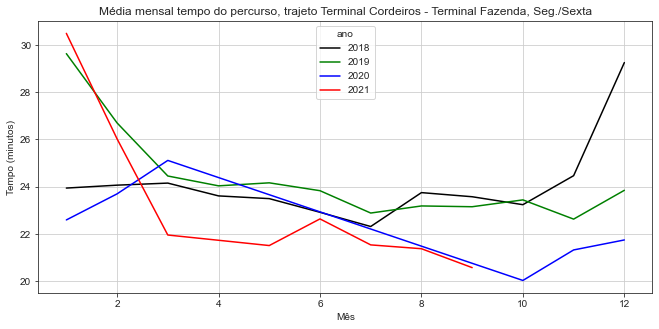

In [10]:
fig, ax = pyplot.subplots(figsize=(11, 5))
mensal = sns.lineplot(data=dados_mes, x='mes', y='mintrajeto', hue='ano', palette=[
                      'black', 'green', 'blue', 'red'], ax=ax)
mensal.set_title(
    "Média mensal tempo do percurso, trajeto Terminal Cordeiros - Terminal Fazenda, Seg./Sexta")
mensal.set_xlabel("Mês", fontsize=10)
mensal.set_ylabel("Tempo (minutos)", fontsize=10)


# Média diária

In [11]:
dados_dias = dados_dias_semana.groupby(['ano', 'dia'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_dias.head()

,index,ano,dia,mintrajeto
0,0,2018,1,23.984906
1,1,2018,2,24.372263
2,2,2018,3,24.937984
3,3,2018,4,23.695324
4,4,2018,5,24.234899


Text(0, 0.5, 'Tempo (minutos)')

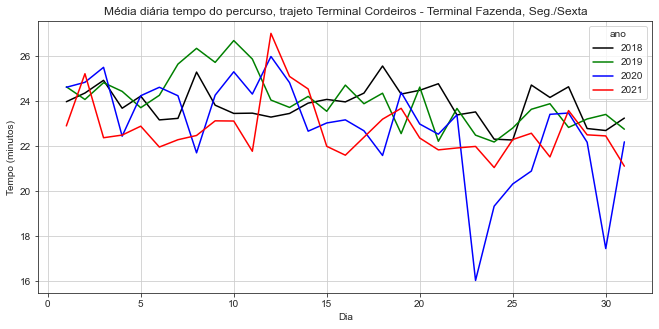

In [12]:
fig, ax = pyplot.subplots(figsize=(11, 5))
diario = sns.lineplot(data=dados_dias, x='dia', y='mintrajeto',
                      hue='ano', palette=['black', 'green', 'blue', 'red'])
diario.set_title(
    "Média diária tempo do percurso, trajeto Terminal Cordeiros - Terminal Fazenda, Seg./Sexta")
diario.set_xlabel("Dia", fontsize=10)
diario.set_ylabel("Tempo (minutos)", fontsize=10)


# Comparação dias da semana

In [13]:
dados_comp_dias_semana = dados_dias_semana.groupby(['ano', 'mes', 'nomediasemana','diasemana'], as_index=False)[
    'mintrajeto'].mean().reset_index()

dados_comp_dias_semana.sort_values(by=['diasemana'], inplace=True)

dados_comp_dias_semana.head()

,index,ano,mes,nomediasemana,diasemana,mintrajeto
97,97,2019,8,Segunda,0,22.122762
27,27,2018,6,Segunda,0,22.656757
137,137,2020,10,Segunda,0,14.888889
62,62,2019,1,Segunda,0,29.174905
32,32,2018,7,Segunda,0,22.843400


Text(0, 0.5, 'Tempo (minutos)')

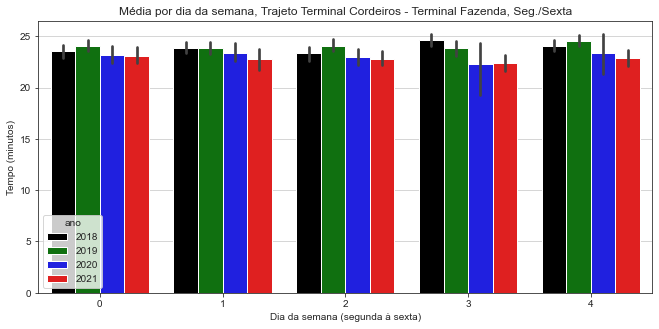

In [14]:
fig, ax = pyplot.subplots(figsize=(11, 5))
dia_semana = sns.barplot(data=dados_dias_semana, x='diasemana', y='mintrajeto',
                         hue='ano', palette=['black', 'green', 'blue', 'red'])
dia_semana.set_title(
    "Média por dia da semana, Trajeto Terminal Cordeiros - Terminal Fazenda, Seg./Sexta")
dia_semana.set_xlabel("Dia da semana (segunda à sexta)", fontsize=10)
dia_semana.set_ylabel("Tempo (minutos)", fontsize=10)
